# Task 2 - Quantum coin toss

Implement a circuit that returns |01> and |10> with equal probability. (WORK IN PROGRESS)

**Requirements:**

* The circuit should consist only of CNOTs, RXs and RYs. 
* Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
* You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
* Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

### Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + $e^{i\phi}$|10⟩ (for example |01⟩  -  |10⟩)?)


## Solution

It suffices to produce the state |01> + |10> and measure it in the computational basis. This can be achieved by the following circuit.

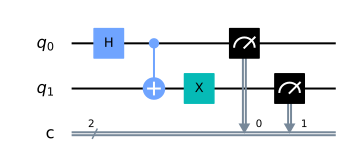

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

bell = QuantumCircuit(2, 2)
bell.h(0)
bell.cnot(0, 1)
bell.x(1)
bell.measure([0, 1], [0, 1])
bell.draw()

Let's verify that this circuit does what we expect.

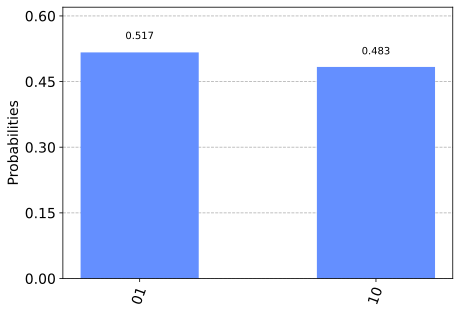

In [2]:
result = execute(bell, Aer.get_backend('qasm_simulator')).result()
counts = result.get_counts(0)
plot_histogram(counts)

To make the simulation more realistic, we will add some noise to the quantum gates, based on the IBM Q Vigo, a 5-qubit device.

In [3]:
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel

provider = IBMQ.load_account()


/mnt/c/Users/dgrad/repos/qosf/qiskit-env/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


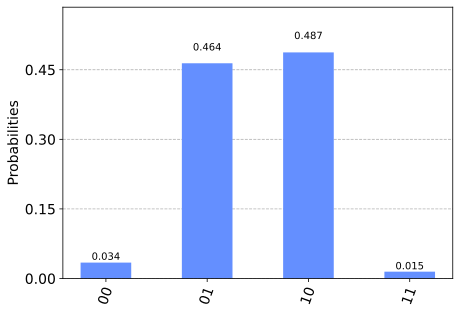

In [4]:

# Build noise model from backend properties
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

result = execute(bell, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts)

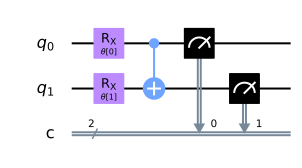

In [17]:
from qiskit.circuit import ParameterVector
bell2 = QuantumCircuit(2, 2)
params = ParameterVector('$\\theta$', 2)
bell2.rx(params[0], 0)
bell2.rx(params[1], 1)
bell2.cnot(0, 1)
bell2.measure([0, 1], [0, 1])
bell2.draw()

In [18]:
def run(theta, shots=1024):
    circuit = bell2.assign_parameters(dict(zip(params, theta)))
    result = execute(circuit, Aer.get_backend('qasm_simulator'),
                     shots=shots,
                     coupling_map=coupling_map,
                     basis_gates=basis_gates,
                     noise_model=noise_model).result()
    counts = result.get_counts(0)
    return counts

def cost_function(shots=1000):
    def cost(theta):
        counts = run(theta, shots=shots)
        value = counts.get('00', 0) + counts.get('11', 0) + abs(counts.get('01', 0) - counts.get('10', 0))
        return value
    return cost
    

In [19]:
import numpy as np
from qiskit.aqua.components.optimizers import COBYLA, AQGD, SPSA

def optimize(initial_point=None, shots=1024):
    optimizer = SPSA()
    if initial_point is None:
        initial_point = np.random.rand(len(params)) * 2 * np.pi
    theta, min_cost, num_evals = optimizer.optimize(
        len(params),
        cost_function(shots),
        initial_point=initial_point)
    return theta


In [20]:
def test(shots=1024):
    theta = optimize(shots=shots)
    print(theta)
    counts = run(theta)
    return plot_histogram(counts)
    
    

[nan nan]


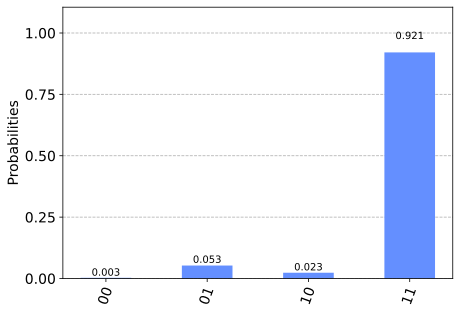

In [21]:
test(1)

[1.51714396 2.49297519]


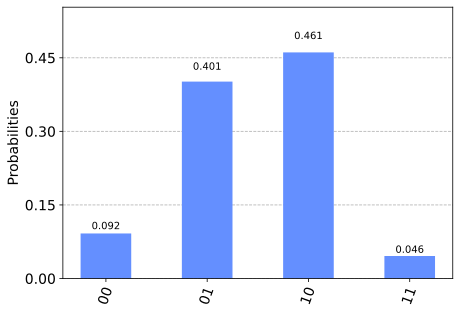

In [22]:
test(10)

[1.54256692 3.36008322]


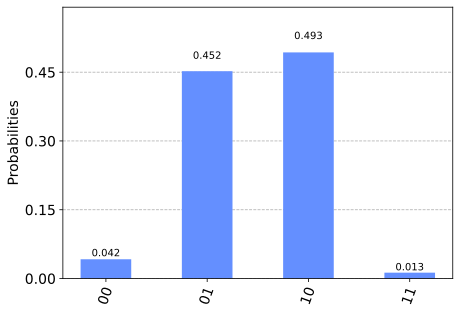

In [11]:
test(100)

[1.56110504 3.11365308]


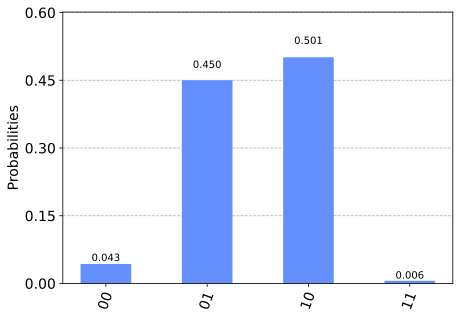

In [23]:
test(1000)

The last parameter vector that we found is suspiciously close to $(\pi/2, \pi)$. If we use these parameters, do we get the Bell state? Let's find out!

In [30]:
circuit = bell2.assign_parameters(dict(zip(params, [np.pi/2, np.pi])))
circuit.remove_final_measurements()
result = execute(circuit, Aer.get_backend('statevector_simulator')).result()
statevector = result.get_statevector()
print(statevector.round(decimals=8))

[ 0.        +0.j         -0.70710678-0.j          0.        -0.70710678j
  0.        -0.j        ]


Yes! This is the state |01> + |10>.